In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import spacy
import re
import nltk
from spacy.tokenizer import Tokenizer

In [2]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
#load spacy models for english
nlp_en = spacy.load("en_core_web_sm")

In [4]:
#load spacy multilingual models 
spacy.cli.download("xx_sent_ud_sm")
nlp_multi = spacy.load("xx_sent_ud_sm")

✔ Download and installation successful
You can now load the package via spacy.load('xx_sent_ud_sm')


In [5]:
dt = pd.read_csv('train.csv')

In [6]:
dt

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [7]:
dt.shape

(12120, 6)

In [8]:
dt.dropna()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


### Language and label distribution

In [9]:
dt['language'].value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64

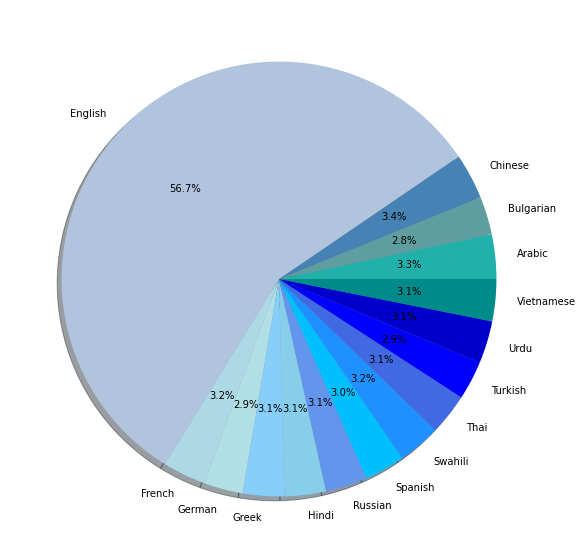

In [10]:
labels, frequencies = np.unique(dt.language.values, return_counts = True)
colors = ['#20B2AA','#5F9EA0','#4682B4','#B0C4DE','#ADD8E6','#B0E0E6','#87CEFA','#87CEEB','#6495ED','#00BFFF','#1E90FF','#4169E1','#0000FF','#0000CD','#008B8B']

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels,colors = colors, autopct = '%1.1f%%',shadow = True)
plt.show()

In [11]:
dt['label'].value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

## Dataset splitting

In [12]:
# english data set
df_en = dt.loc[dt['lang_abv'] == 'en']
df_en

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
7,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [13]:
df_en['label'].value_counts()

0    2427
2    2277
1    2166
Name: label, dtype: int64

In [14]:
#english x
x_en = df_en.premise.values +' '+ df_en.hypothesis.values
#english y 
y_en = df_en.label.values
# split train and test
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(x_en, y_en, test_size=0.3, random_state=100)

In [15]:
# multilingual dataset
df_multi = dt.loc[dt['language'].isin(['Russian','Spanish','Greek'])]
df_multi

,id,premise,hypothesis,lang_abv,language,label
9,8c10229663,Через каждые сто градусов пятна краски меняют ...,Краска изменяется в соответствии с цветом.,ru,Russian,0
23,1ec4761d9d,"Уверяю вас, сэр, что я был полностью осведомле...",От меня скрыли множество деталей.,ru,Russian,2
28,8b8a91643a,27 La dificultad aumenta a medida que la neces...,27 La dificultad depende de las modificaciones.,es,Spanish,0
30,a2a8b36437,"Κατά συνέπεια, οι κυβερνητικοί υπεύθυνοι λήψης...",Οι κυβερνητικοί εκπρόσωποι αρνούνται να αλλάξο...,el,Greek,2
71,2b2010a718,Με την πιο εύκολη αφομοίωση με την κοινότητα A...,Οι Εβραίοι ενσωματώθηκαν ευκολότερα στην Αγγλι...,el,Greek,0
...,...,...,...,...,...,...
12069,a8a40723d1,Το αγαπημένο μου παράδειγμα παραμένει ο βάτραχ...,Έχω ένα αγαπημένο παράδειγμα.,el,Greek,0
12075,751c6b8694,В этом стихотворении Иоаким живет и бежит на к...,В стихотворении Хоакин жил в своей машине.,ru,Russian,2
12089,f9c96f2a5e,"Después viene Bona, un centro de cestería que ...",Bona es el hogar de la danza kecak.,es,Spanish,0
12104,eae412f48e,"Да, - сказал Огле, - это правда. Но были и те,...",Огл никогда не упоминал противников существующ...,ru,Russian,2


In [16]:
df_multi['label'].value_counts()

2    381
0    370
1    363
Name: label, dtype: int64

In [17]:
#multi x
x_multi = df_multi.premise.values +' '+ df_multi.hypothesis.values
#english y 
y_multi = df_multi.label.values
# split train and test
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(x_multi, y_multi, test_size=0.3, random_state=10)

## spacy english tokenizer 

In [18]:
import string
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

stopword_list = stopwords.words('english')
punctuations = string.punctuation

def spacy_en_tokenizer(text):

    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)
    
    doc = nlp_en(text)
    
    # lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]
    
    
    # removing stopwords and punctuations
    lemmas_nostop = [token for token in lemmas if token not in stopword_list and token not in punctuations]
    
    
    # creating ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_nostop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_nostop,3)]
    
    

    all_tokens = list()
    all_tokens.extend(lemmas_nostop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

### create the vectors

In [19]:
vect=CountVectorizer(analyzer=spacy_en_tokenizer)

vect.fit(X_train_en) 
#Creating the vectors
X_train_en_tok = vect.transform(X_train_en) 
print('done')

X_test_en_tok =vect.transform(X_test_en)

done


## multi spacy tokenizer

In [34]:
def spacy_multi_tokenizer(text):

    # substituting all space characters with a single space --> commented because it makes the text empty
    #text = re.sub('\s+', ' ', text)
    
    doc = nlp_multi(text)
    #tokenizer = Tokenizer(nlp_multi.vocab)
    all_tokens = [s for s in doc]
    
    return all_tokens

In [21]:
## the vectors
vect=CountVectorizer(analyzer=spacy_multi_tokenizer)

vect.fit(X_train_multi) 
#Creating the vectors
X_train_multi_tok = vect.transform(X_train_multi) 
print('done')

X_test_multi_tok =vect.transform(X_test_multi)

done


In [51]:
## saving
with open('multi_x_train_tok.pkl','wb') as outfile:
    pickle.dump(X_train_multi_tok,outfile)
with open('multi_x_test_tok.pkl','wb') as outfile:
    pickle.dump(X_test_multi_tok,outfile)

In [12]:
with open('multi_x_train_tok.pkl',mode='br') as inputfile:
    X_train_en_tok = pickle.load(inputfile)
with open('multi_x_test_tok.pkl',mode='br') as inputfile:
    X_test_en_tok = pickle.load(inputfile)

## Classification with Naive Bayes Classifier --> english

### default tokenization

In [22]:
NBC_pipeline = Pipeline([
    ('vect', CountVectorizer()), #tokenization
    ('sel', SelectKBest(chi2, k= 10)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

NBC_pipeline.fit(X_train_en,y_train_en)
predictions = NBC_pipeline.predict(X_test_en)

print('Classification report:')
print(classification_report(y_test_en, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_en, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.36      0.90      0.51       703
           1       0.42      0.06      0.11       667
           2       0.61      0.18      0.28       691

    accuracy                           0.39      2061
   macro avg       0.46      0.38      0.30      2061
weighted avg       0.46      0.39      0.30      2061

Confusion matrix:
[[633  32  38]
 [583  41  43]
 [540  25 126]]


### with spacy tokenizer

In [23]:
NBC_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k= 15)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

NBC_pipeline.fit(X_train_en_tok,y_train_en)
predictions = NBC_pipeline.predict(X_test_en_tok)

print('Classification report:')
print(classification_report(y_test_en, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_en, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.95      0.51       703
           1       0.22      0.02      0.03       667
           2       0.65      0.09      0.15       691

    accuracy                           0.36      2061
   macro avg       0.41      0.35      0.23      2061
weighted avg       0.41      0.36      0.23      2061

Confusion matrix:
[[665  20  18]
 [642  11  14]
 [614  18  59]]


## Classification with Naive Bayes Classifier --> multi

In [24]:
NBC_pipeline = Pipeline([
    ('vect', CountVectorizer()), #tokenization
    ('sel', SelectKBest(chi2, k= 50)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

NBC_pipeline.fit(X_train_multi,y_train_multi)
predictions = NBC_pipeline.predict(X_test_multi)

print('Classification report:')
print(classification_report(y_test_multi, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_multi, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.24      0.12      0.16       111
           1       0.31      0.18      0.23       110
           2       0.36      0.69      0.48       114

    accuracy                           0.33       335
   macro avg       0.31      0.33      0.29       335
weighted avg       0.31      0.33      0.29       335

Confusion matrix:
[[13 27 71]
 [23 20 67]
 [18 17 79]]


### with spacy tokenizer

In [25]:
NBC_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k= 15)),  # feature selection
    ('learner', MultinomialNB(alpha = 1))  # learning algorithm
])

NBC_pipeline.fit(X_train_multi_tok,y_train_multi)
predictions = NBC_pipeline.predict(X_test_multi_tok)

print('Classification report:')
print(classification_report(y_test_multi, predictions, zero_division = 1))
print('Confusion matrix:')
cm = confusion_matrix(y_test_multi, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       111
           1       1.00      0.00      0.00       110
           2       0.34      1.00      0.51       114

    accuracy                           0.34       335
   macro avg       0.78      0.33      0.17       335
weighted avg       0.78      0.34      0.17       335

Confusion matrix:
[[  0   0 111]
 [  0   0 110]
 [  0   0 114]]


## SVM --> english

### default tokenizer

Classification report:
              precision    recall  f1-score   support

           0       0.37      0.76      0.50       703
           1       0.42      0.11      0.17       667
           2       0.53      0.36      0.43       691

    accuracy                           0.41      2061
   macro avg       0.44      0.41      0.37      2061
weighted avg       0.44      0.41      0.37      2061

Confusion matrix:
[[533  57 113]
 [494  72 101]
 [404  41 246]]


C:\Users\eleon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


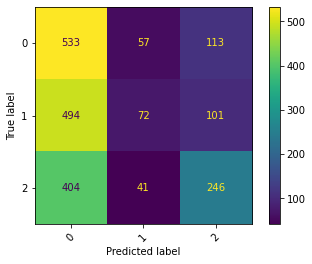

In [26]:
svm_pipeline = Pipeline([
    ('vect', CountVectorizer()), #tokenization
    ('sel', SelectKBest(chi2, k=15)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(X_train_en,y_train_en)
predictions = svm_pipeline.predict(X_test_en)

print('Classification report:')
print(classification_report(y_test_en, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_en, predictions)
print(cm)

plot_confusion_matrix(svm_pipeline, X_test_en, y_test_en)  
plt.xticks(rotation=45)
plt.show()

In [28]:
param_grid = [{'sel__k': [5,8, 10, 15], 'learner__C': [0.01, 0.05, 1, 10, 100]}]

opt_pipeline = Pipeline([
    ('vect', CountVectorizer()), #tokenization
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, n_jobs = n_jobs, verbose=True).fit(X_train_en,y_train_en)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [29]:
SVM_opt_search.best_params_

{'learner__C': 0.05, 'sel__k': 5}

In [30]:
opt_predictions = SVM_opt_search.best_estimator_.predict(X_test_en)

print('Classification report:')
print(classification_report(y_test_en, opt_predictions, zero_division = 1))
print('Confusion matrix:')
cm = confusion_matrix(y_test_en, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.37      0.83      0.51       703
           1       1.00      0.00      0.00       667
           2       0.52      0.38      0.44       691

    accuracy                           0.41      2061
   macro avg       0.63      0.40      0.32      2061
weighted avg       0.63      0.41      0.32      2061

Confusion matrix:
[[582   0 121]
 [549   0 118]
 [431   0 260]]


### spacy tokenizer

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.92      0.51       703
           1       0.36      0.06      0.10       667
           2       0.64      0.09      0.15       691

    accuracy                           0.36      2061
   macro avg       0.45      0.36      0.25      2061
weighted avg       0.45      0.36      0.26      2061

Confusion matrix:
[[649  35  19]
 [612  41  14]
 [593  39  59]]


C:\Users\eleon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


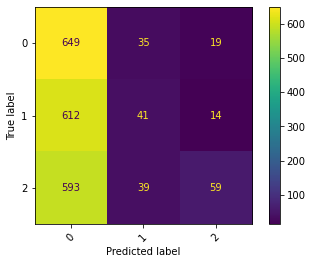

In [31]:
svm_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=15)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(X_train_en_tok,y_train_en)
predictions = svm_pipeline.predict(X_test_en_tok)

print('Classification report:')
print(classification_report(y_test_en, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_en, predictions)
print(cm)

plot_confusion_matrix(svm_pipeline, X_test_en_tok, y_test_en)  
plt.xticks(rotation=45)
plt.show()

In [32]:
param_grid = [{'sel__k': [3, 5, 8, 10, 15], 'learner__C': [0.05, 0.1, 1, 10,15]}]

opt_pipeline = Pipeline([
    
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, n_jobs = n_jobs, verbose=True).fit(X_train_en_tok,y_train_en)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [33]:
SVM_opt_search.best_params_

{'learner__C': 10, 'sel__k': 8}

In [34]:
opt_predictions = SVM_opt_search.best_estimator_.predict(X_test_en_tok)

print('Classification report:')
print(classification_report(y_test_en, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_en, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.93      0.51       703
           1       0.36      0.06      0.10       667
           2       0.63      0.09      0.15       691

    accuracy                           0.36      2061
   macro avg       0.45      0.36      0.25      2061
weighted avg       0.45      0.36      0.26      2061

Confusion matrix:
[[651  32  20]
 [612  40  15]
 [594  38  59]]


## SVM --> multi

### default tokenizer

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.77      0.51       111
           1       0.34      0.11      0.17       110
           2       0.62      0.39      0.48       114

    accuracy                           0.43       335
   macro avg       0.45      0.43      0.39       335
weighted avg       0.45      0.43      0.39       335

Confusion matrix:
[[86 15 10]
 [81 12 17]
 [61  8 45]]


C:\Users\eleon\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


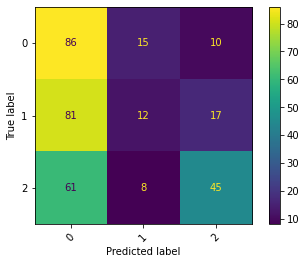

In [35]:
svm_pipeline = Pipeline([
    ('vect', CountVectorizer()), #tokenization
    ('sel', SelectKBest(chi2, k=15)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(X_train_multi,y_train_multi)
predictions = svm_pipeline.predict(X_test_multi)

print('Classification report:')
print(classification_report(y_test_multi, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_multi, predictions)
print(cm)

plot_confusion_matrix(svm_pipeline, X_test_multi, y_test_multi)  
plt.xticks(rotation=45)
plt.show()

In [36]:
param_grid = [{'sel__k': [15, 16, 17, 18], 'learner__C': [0.01, 0.02, 0.03, 0.05, 0.08]}]

opt_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, n_jobs = n_jobs, verbose=True).fit(X_train_multi,y_train_multi)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [37]:
SVM_opt_search.best_params_

{'learner__C': 0.01, 'sel__k': 16}

In [38]:
opt_predictions = SVM_opt_search.best_estimator_.predict(X_test_multi)

print('Classification report:')
print(classification_report(y_test_multi, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_multi, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.78      0.51       111
           1       0.28      0.07      0.12       110
           2       0.60      0.39      0.48       114

    accuracy                           0.42       335
   macro avg       0.42      0.42      0.37       335
weighted avg       0.42      0.42      0.37       335

Confusion matrix:
[[87 14 10]
 [82  8 20]
 [62  7 45]]


### Spacy tokenizer

In [27]:
param_grid = [{'sel__k': [10, 15, 16, all], 'learner__C': [0.01, 0.02, 0.03, 0.05, 0.08]}]

opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, n_jobs = n_jobs, verbose=True).fit(X_train_multi_tok,y_train_multi)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\eleon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\eleon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\eleon\anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\eleon\anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\eleon\anacon

In [28]:
SVM_opt_search.best_params_

{'learner__C': 0.01, 'sel__k': 10}

In [29]:
opt_predictions = SVM_opt_search.best_estimator_.predict(X_test_multi_tok)

print('Classification report:')
print(classification_report(y_test_multi, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_multi, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00       110
           2       0.34      1.00      0.51       114

    accuracy                           0.34       335
   macro avg       0.11      0.33      0.17       335
weighted avg       0.12      0.34      0.17       335

Confusion matrix:
[[  0   0 111]
 [  0   0 110]
 [  0   0 114]]


C:\Users\eleon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eleon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eleon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random forest --> english

### default tokenizer 

In [42]:
param_grid = [{'sel__k': [8, 10, 12], 'learner__n_estimators': [300, 500, 700]}]

opt_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier(bootstrap = True))  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
opt_search = GridSearchCV(opt_pipeline, param_grid, cv=5, n_jobs = n_jobs, verbose=True).fit(X_train_en,y_train_en)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [43]:
opt_search.best_params_

{'learner__n_estimators': 500, 'sel__k': 10}

In [44]:
opt_search.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(min_df=5)),
                ('sel',
                 SelectKBest(score_func=<function chi2 at 0x0000026ECD158820>)),
                ('tfidf', TfidfTransformer()),
                ('learner', RandomForestClassifier(n_estimators=500))])

In [45]:
opt_predictions = opt_search.best_estimator_.predict(X_test_en)

print('Classification report:')
print(classification_report(y_test_en, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_en, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.37      0.77      0.50       703
           1       0.40      0.09      0.14       667
           2       0.53      0.35      0.42       691

    accuracy                           0.41      2061
   macro avg       0.43      0.40      0.36      2061
weighted avg       0.43      0.41      0.36      2061

Confusion matrix:
[[539  53 111]
 [500  58 109]
 [412  34 245]]


### spacy tokenizer

In [46]:
param_grid = [{'sel__k': [8, 10, 5], 'learner__n_estimators': [100, 50, 500]}]

opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier(bootstrap = True))  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
opt_search = GridSearchCV(opt_pipeline, param_grid, cv=5, n_jobs = n_jobs, verbose=True).fit(X_train_en_tok,y_train_en)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [47]:
opt_search.best_params_

{'learner__n_estimators': 500, 'sel__k': 8}

In [48]:
opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x0000026ECD158820>)),
                ('tfidf', TfidfTransformer()),
                ('learner', RandomForestClassifier(n_estimators=500))])

In [49]:
opt_predictions = opt_search.best_estimator_.predict(X_test_en_tok)

print('Classification report:')
print(classification_report(y_test_en, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_en, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.93      0.51       703
           1       0.36      0.06      0.10       667
           2       0.63      0.09      0.15       691

    accuracy                           0.36      2061
   macro avg       0.45      0.36      0.25      2061
weighted avg       0.45      0.36      0.26      2061

Confusion matrix:
[[651  32  20]
 [612  40  15]
 [594  38  59]]


## Random forest --> multi

In [50]:
param_grid = [{'sel__k': [8, 10, 12], 'learner__n_estimators': [300, 500, 700]}]

opt_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier(bootstrap = True))  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
opt_search = GridSearchCV(opt_pipeline, param_grid, cv=5, n_jobs = n_jobs, verbose=True).fit(X_train_multi,y_train_multi)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [51]:
opt_search.best_params_

{'learner__n_estimators': 500, 'sel__k': 8}

In [52]:
opt_search.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(min_df=5)),
                ('sel',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x0000026ECD158820>)),
                ('tfidf', TfidfTransformer()),
                ('learner', RandomForestClassifier(n_estimators=500))])

In [53]:
opt_predictions = opt_search.best_estimator_.predict(X_test_multi)

print('Classification report:')
print(classification_report(y_test_multi, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_multi, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.20      0.02      0.03       111
           1       0.34      0.78      0.48       110
           2       0.62      0.40      0.49       114

    accuracy                           0.40       335
   macro avg       0.39      0.40      0.33       335
weighted avg       0.39      0.40      0.33       335

Confusion matrix:
[[  2 100   9]
 [  5  86  19]
 [  3  65  46]]


In [30]:
param_grid = [{'sel__k': [8, 10, 5,15,10], 'learner__n_estimators': [100, 50, 500,40,200]}]

opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier(bootstrap = True))  # learning algorithm
])

n_jobs = 3 #Number of jobs to run in parallel
opt_search = GridSearchCV(opt_pipeline, param_grid, cv=5, n_jobs = n_jobs, verbose=True).fit(X_train_multi_tok,y_train_multi)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [31]:
opt_search.best_params_

{'learner__n_estimators': 100, 'sel__k': 8}

In [32]:
opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x00000135C39788B0>)),
                ('tfidf', TfidfTransformer()),
                ('learner', RandomForestClassifier())])

In [33]:
opt_predictions = opt_search.best_estimator_.predict(X_test_multi_tok)

print('Classification report:')
print(classification_report(y_test_multi, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test_multi, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.00      0.00      0.00       110
           2       0.34      1.00      0.51       114

    accuracy                           0.34       335
   macro avg       0.11      0.33      0.17       335
weighted avg       0.12      0.34      0.17       335

Confusion matrix:
[[  0   0 111]
 [  0   0 110]
 [  0   0 114]]


C:\Users\eleon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eleon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eleon\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
